#Overview

In this project, I build an algorithm to predict whether a particular in lending club will be a success or a failure. A successful loan is a loan that is fully paid off. A failure loan is a loan either in default state or charged off state, where there is no reasonable expectation that the loan will be paid off. 

In [1]:
# Load all the data 
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

In [2]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [3]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [4]:
df = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3a_securev1.csv',skiprows=1)
dfb = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3b_securev1.csv',skiprows=1)
dfc = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3c_securev1.csv',skiprows=1)
dfd = pd.read_csv('/Volumes/mac/Work/JobHunt/Incubator/ipynb/LoanStats3d_securev1.csv',skiprows=1)

/Users/jingfengli/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/jingfengli/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
totdf = df
totdf = df.append(dfb)
totdf = totdf.append(dfc)
totdf = totdf.append(dfd)
print totdf.shape

(646398, 56)


In [6]:
import numpy as np

##To deal with the abnormality of the input data, for instance, to deal with the placeholders

In [7]:
# success: 1, failure: -1, others: 0, questionable: 0.5
totdf['stat'] = pd.Series(np.zeros(np.shape(totdf['id'])))

success = ['Fully Paid']
failure = ['Charged Off','Default']
question = ['In Grace Period','Late (16-30 days)','Late (31-120 days)']

for i in success:
    totdf.stat[totdf.loan_status == i] = 1

for i in failure:
    totdf.stat[totdf.loan_status == i] = -1

for i in question:
    totdf.stat[totdf.loan_status == i] = 0.5

# ONLY look at the data for failure and success, no questionable or other type
CleanUpRecord = totdf.loc[(totdf.stat==1)|(totdf.stat==-1)]
df = CleanUpRecord

/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
print 'Failure / (Success + Failure)'
print (totdf.stat[totdf.stat == -1]).count()*1.0/((totdf.stat[totdf.stat == 1]).count() + (totdf.stat[totdf.stat == -1]).count())

Failure / (Success + Failure)
0.178621674682


# Distribution of loans from Lending Club

In [9]:
df.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'fico_range_low',
       u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq',
       u'mths_since_last_record', u'open_acc', u'pub_rec', u'revol_bal',
       u'revol_util', u'total_acc', u'initial_list_status', u'out_prncp',
       u'out_prncp_inv', u'total_pymnt', u'total_pymnt_inv',
       u'total_rec_prncp', u'total_rec_int', u'total_rec_late_fee',
       u'recoveries', u'collection_recovery_fee', u'last_pymnt_d',
       u'last_pymnt_amnt', u'next_pymnt_d', u'last_credit_pull_d',
       u'last_fico_range_high', u'last_fico_range_low',
       u'collections_12_m

# There is two FICO info, WHICH ONE TO USE?!!!
Use the one did not marked with last, because that is the one that is av ailabel to the user.


In [10]:
# # There is two FICO info, WHICH ONE TO USE?!!!
# # Let us explore what is about
# MisMatch = []
# for i in xrange(len(df.url)):
#     if not df.last_fico_range_high.iloc[i] == df.fico_range_high.iloc[i]:
#         MisMatch.append(i)

In [11]:
relevant = [ 'annual_inc',
             'dti', 
             'emp_length',
             'fico_range_high',
             'fico_range_low',
             'home_ownership',
             'loan_amnt',
             'open_acc',
             'policy_code',
             'pub_rec',
             'sub_grade',
             'term',
             'total_acc',
#              'last_credit_pull_d',
# #              'last_fico_range_high',
#              'last_fico_range_low',
#             'earliest_cr_line',
#             'purpose',
#              'funded_amnt',
#              'grade',
            ]

X = df[relevant]
y = df['stat']
X_y = df[relevant +['stat']]

## reweight the y to deal with the imbalance 
# Reweighting does not seem to work now. 
# let me just resample
# y_1 = len(y[y== 1])
# y_0 = len(y[y== -1])
# print pd.unique(y)
# y[y==-1] = y_1
# y[y== 1] = y_0
# print pd.unique(y)


In [344]:
relevant = [ 'annual_inc',
             'dti', 
             'emp_length',
#              'fico_range_high',
#              'fico_range_low',
             'home_ownership',
             'loan_amnt',
             'open_acc',
             'policy_code',
             'pub_rec',
             'sub_grade',
             'term',
             'total_acc',
#              'last_credit_pull_d',
             'last_fico_range_high',
             'last_fico_range_low',
#             'earliest_cr_line',
#             'purpose',
#              'funded_amnt',
#              'grade',
            ]

X_cheat = df[relevant]
# y = df['stat']
# X_y = df[relevant +['stat']]

## reweight the y to deal with the imbalance 
# Reweighting does not seem to work now. 
# let me just resample
# y_1 = len(y[y== 1])
# y_0 = len(y[y== -1])
# print pd.unique(y)
# y[y==-1] = y_1
# y[y== 1] = y_0
# print pd.unique(y)


In [345]:
List2DictT = List2Dict_Transformer(str_keys=['home_ownership'])
X_trans_cheat = List2DictT.fit_transform(X_cheat)
DictVectorT = DictVectorizer(sparse=False)
X_vect_cheat = DictVectorT.fit_transform(X_trans_cheat)

RFfit_cheat =RandomForestClassifier(n_estimators=300)
RFfit_cheat.fit(X_vect_cheat,y)

y_prob_cheat=RFfit_cheat.predict_prob(X_vect_cheat)

AttributeError: 'RandomForestClassifier' object has no attribute 'predict_prob'

In [12]:

############################
## Create otholgonal datasets

def rebalanceXy(X,y):
    # permute the data, just in case it is order:
    import numpy as np
    y = np.array(y)
    X = np.array(X)
    perm = np.random.permutation(len(y))
    X = X[perm]
    y = y[perm]
    # determine which one is not balanced
    y_uniq = np.unique(y)
    if len(y[y==y_uniq[0]]) < len(y)/2:
        y_less,y_more = y_uniq[0], y_uniq[1]
    else:
        y_less,y_more = y_uniq[1], y_uniq[0]
    
    n_less = len(y[y==y_less])
    n_more = len(y[y==y_more])
    # rebalance
    # The idea is to select all the y_less data, but not all the y_more data. 
    
    yy_less = y[y==y_less]
    XX_less = X[y==y_less]
    
    yy_more = y[y==y_more]
    XX_more = X[y==y_more]
    
    XX_reblance = []
    yy_reblance = []
    Xy_reblance = []
    for i in xrange(n_more/n_less + 1):
        St = i*n_less
        Ed = (i+1)*n_less
        if Ed <= n_more:            
            XX_tmp = np.append(XX_more[St:Ed],XX_less,0)
            yy_tmp = np.append(yy_more[St:Ed],yy_less,0)
            perm = np.random.permutation(n_less*2)
            Xy_reblance.append([XX_tmp[perm], yy_tmp[perm]])
        else:
            Diff = np.random.random_integers(0,n_more-1,Ed-n_more)
            np.append(XX_more[St:Ed], XX_more[Diff],0)
            
            XX_tmp = np.append(np.append(XX_more[St:Ed], XX_more[Diff],0), XX_less,0)
            yy_tmp = np.append(np.append(yy_more[St:Ed], yy_more[Diff],0), yy_less,0)
            perm = np.random.permutation(n_less*2)
            Xy_reblance.append([XX_tmp[perm], yy_tmp[perm]])
        
    
    return Xy_reblance


    


# split into train and test datasets
# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [16]:
len(y[y==-1])

33391

In [17]:
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin
class List2Dict_Transformer(BaseEstimator,TransformerMixin):
    '''
    Expects a data-frame object. 
    '''
    def __init__(self, str_keys=[]):
        self.str_keys = str_keys
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        grademap = {'A':10,"B":20,"C":30,"D":40,"E":50,"F":60,"G":70,"H":80}
        X_dict = []
        X_keys = X.columns
        for i in xrange(len(X)):
            x_dict = {}
            for key in X_keys:
                if key in self.str_keys:
                    x_dict[key + '_' + X[key].iloc[i]] = 1
                elif key == u'emp_length':
                    if X[key].iloc[i][0] == 'n':
                        x_dict[key] = -1
                    elif X[key].iloc[i][0] == '<':
                        x_dict[key] = 0
                    else:
                        x_dict[key] = int(X[key].iloc[i][:2])
                elif key == 'sub_grade':
#                     print X[key].iloc[i][0]
                    base = grademap[X[key].iloc[i][0]]
                    x_dict[key] = base + int(X[key].iloc[i][1])
                elif key == 'term':
                    x_dict[key] = int(X[key].iloc[i][:3])
                else:
                    x_dict[key] = X[key].iloc[i]
            X_dict.append(x_dict)
        return X_dict


In [18]:
List2DictT = List2Dict_Transformer(str_keys=['home_ownership'])
X_trans = List2DictT.fit_transform(X)
DictVectorT = DictVectorizer(sparse=False)
X_vect = DictVectorT.fit_transform(X_trans)

In [19]:
import dill
with open('./X_vect.pkl','wb') as out_strm:
    dill.dump(X_vect,out_strm)


In [145]:
# Save the fit
# import dill
# with open('./List2DictT.pkl','wb') as out_strm:
#     dill.dump(List2DictT,out_strm)
# with open('./DictVectorT.pkl','wb') as out_strm:
#     dill.dump(DictVectorT,out_strm)
# with open('./RFfit.pkl','wb') as out_strm:
#     dill.dump(RFfit,out_strm)


In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33)
Xy_train_bal = rebalanceXy(X_train,y_train)

In [337]:
len(Xy_train_bal[0][1])

44596

array([[  2.40000000e+04,   2.76500000e+01,   1.00000000e+01, ...,
          2.20000000e+01,   3.60000000e+01,   9.00000000e+00],
       [  3.00000000e+04,   1.00000000e+00,   0.00000000e+00, ...,
          3.40000000e+01,   6.00000000e+01,   4.00000000e+00],
       [  1.22520000e+04,   8.72000000e+00,   1.00000000e+01, ...,
          3.50000000e+01,   3.60000000e+01,   1.00000000e+01],
       ..., 
       [  6.30780000e+04,   3.17000000e+01,   1.00000000e+01, ...,
          4.20000000e+01,   6.00000000e+01,   2.80000000e+01],
       [  5.40000000e+04,   1.32200000e+01,   0.00000000e+00, ...,
          1.10000000e+01,   3.60000000e+01,   2.10000000e+01],
       [  5.00000000e+04,   1.26300000e+01,   1.00000000e+01, ...,
          2.10000000e+01,   3.60000000e+01,   3.00000000e+01]])

In [27]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression

TotRFMOD = []
TotGBGMOD = []
TotLGRMOD = []
for i in xrange(len(Xy_train_bal)):
    XX_bal = Xy_train_bal[i][0]
    yy_bal = Xy_train_bal[i][1]

    RFfit =RandomForestClassifier(n_estimators=300)
    RFfit.fit(XX_bal,yy_bal)
    TotRFMOD.append(RFfit)
    
    clf=GradientBoostingClassifier(n_estimators=1000,max_depth=5,
                               learning_rate=0.05,max_features='sqrt')
    clf.fit(XX_bal,yy_bal)
    TotGBGMOD.append(clf)
    
    clf2=LogisticRegression()
    clf2.fit(XX_bal,yy_bal)
    TotLGRMOD.append(clf2)
    
 

In [28]:
TotModes = TotRFMOD + TotGBGMOD + TotLGRMOD

import dill
with open('TotModes,pkl','wb') as out_strm:
    dill.dump(TotModes,out_strm)

['annual_inc',
 'dti',
 'emp_length',
 'fico_range_high',
 'fico_range_low',
 'home_ownership_ANY',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'loan_amnt',
 'open_acc',
 'policy_code',
 'pub_rec',
 'sub_grade',
 'term',
 'total_acc']

In [80]:
a=TotRFMOD[1]
a.feature_importances_
importance=[(DictVectorT.feature_names_[i],a.feature_importances_[i]) for i in xrange(len(a.feature_importances_))]

importance = sorted(importance,key = lambda tup:tup[1],reverse=True)
print importance


[('dti', 0.1508685928196716), ('annual_inc', 0.13692133735420761), ('loan_amnt', 0.12211874580051592), ('sub_grade', 0.11996917410243554), ('total_acc', 0.11263709925340408), ('open_acc', 0.092648392903049562), ('emp_length', 0.074658986728847437), ('fico_range_low', 0.064074135305509441), ('fico_range_high', 0.062755123134168991), ('term', 0.019984832525629676), ('pub_rec', 0.014157857438953174), ('home_ownership_MORTGAGE', 0.010746094673376984), ('home_ownership_RENT', 0.010694809810878798), ('home_ownership_OWN', 0.007455018225750093), ('home_ownership_OTHER', 0.00023341699429887925), ('home_ownership_NONE', 7.0199962168635859e-05), ('home_ownership_ANY', 6.1829671339511274e-06), ('policy_code', 0.0)]


In [2]:
# from collections import OrderedDict

# import pandas as pd

# from bokeh.charts import Bar, output_file, show
# from bokeh.sampledata.olympics2014 import data
# import bokeh
# from bokeh.models import HoverTool, ColumnDataSource


# # get the countries and we group the data by medal type
# gold = meanFico.Paid
# silver = 1-meanFico.Paid
# countries =[str(meanFico.index[i]) for i in xrange(len(gold))]

# for i in xrange(len(gold)):
#     meanFico['WTF'].iloc[i] = (meanFico.index[i])

# gold = gold.iloc[2:]
# silver = silver.iloc[2:]
# countries = countries[2:]
# # build a dict containing the grouped data
# medals = OrderedDict(silver=silver, gold=gold)
# fscor = meanFico.WTF.iloc[2:]


In [1]:
# output_notebook()
# TOOLS = "hover,save"
# bar = Bar(medals, countries, title="Pay Off versus Default", 
#           stacked=True,width=1500, height=800,tools = TOOLS,
#           ylabel='Probability',
#           xlabel='FICO credit score')
# source = ColumnDataSource(
#     data=dict(
#         gold = fscor,
#         silver = silver,
#         fscor = fscor,
#      )
# )

# hover = bar.select(dict(type=HoverTool))
# hover.tooltips = OrderedDict([
#     ("Pay off chance", "@gold"),
#     ("Default chance", "@silver"),
#     ("FICO score", "$x"),
# ])
# show(bar)

In [365]:
Fico = CleanUpRecord
Fico['fico']=Fico.fico_range_high
Fico['Paid'] = Fico['stat']
Fico.Paid[Fico['Paid'] == -1] =0
meanFico=Fico.groupby(['fico']).mean()
cntFico=Fico.groupby(['fico']).count()

# print pd.unique(Fico.stat)

/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jingfengli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in th

In [3]:
# output_notebook()
# TOOLS = "hover,save,box_zoom,reset"
# bb = cntFico.Paid.iloc[2:]
# newmedals = OrderedDict(bb=bb)

# bar = Bar(newmedals, countries, title="Distribution of Loans", 
#           width=1500, height=800,tools = TOOLS,
#           ylabel='Number of Loans',
#           xlabel='FICO credit score')
# source = ColumnDataSource(
#     data=dict(
#         bb = bb,
#      )
# )

# hover = bar.select(dict(type=HoverTool))
# hover.tooltips = OrderedDict([
#     ("Loans (#)", "@bb"),
# #     ("Default chance", "@silver"),
#     ("FICO score", "$x"),
# ])
# show(bar)

In [390]:
type(silver)

pandas.core.series.Series

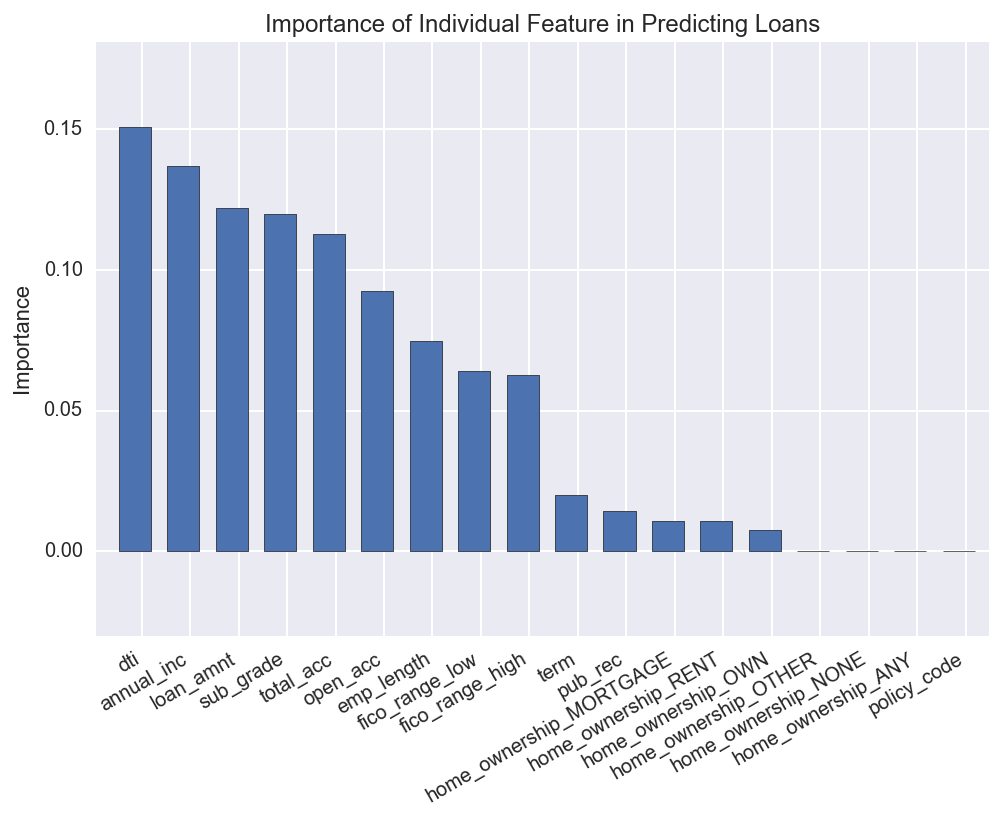

In [331]:
import matplotlib.pyplot as plt
pp = [importance[i][1] for i in xrange(18)]
labels= [importance[i][0] for i in xrange(18)]
# print pp



# This gives me the plot:
# pNYC10 = sns.factorplot(x=np.linspace(0,18,18),y=np.array(pp),aspect=3)
# pNYC10.set_xticklabels(rotation=30)
# pNYC10.set_axis_labels("Water System - NYC, 2015", "Complaints")

fig, ax = plt.subplots()
ax.bar(np.linspace(0,18,18),np.array(pp),width=0.7)
plt.xticks(np.linspace(0,18,18)+0.5, labels)
fig.autofmt_xdate()

plt.title('Importance of Individual Feature in Predicting Loans')
plt.ylabel('Importance')
plt.xlim([-0.5,19])
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()
 
    


In [51]:
from sklearn.linear_model import LogisticRegression
# combine all the models
# y_cmb = []
# for RF in TotRFMOD:
#     y_cmb.append(RF.predict_proba(X_train)[:,0])

# for RF in TotGBGMOD:
#     y_cmb.append(RF.predict_proba(X_train)[:,0])

# for RF in TotLGRMOD:
#     y_cmb.append(RF.predict_proba(X_train)[:,0])

    
y_cmb_pred = []
for RF in TotRFMOD:
    y_cmb_pred.append(RF.predict(X_train))

for RF in TotGBGMOD:
    y_cmb_pred.append(RF.predict(X_train))

for RF in TotLGRMOD:
    y_cmb_pred.append(RF.predict(X_train))


In [53]:
# 
np.unique(y_train)
# print (np.array(y_cmb)).shape
# print len(y_train)


array([-1.,  1.])

In [68]:
FinalLGR = LogisticRegression(class_weight={-1:0.8,1:0.2})
FinalLGR.fit(np.array(y_cmb)[6:,:].T,y_train)

LogisticRegression(C=1.0, class_weight={1: 0.2, -1: 0.8}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [59]:
# y_cmb_test = []
# for RF in TotRFMOD:
#     y_cmb_test.append(RF.predict_proba(X_test)[:,0])

# for RF in TotGBGMOD:
#     y_cmb_test.append(RF.predict_proba(X_test)[:,0])

# for RF in TotLGRMOD:
#     y_cmb_test.append(RF.predict_proba(X_test)[:,0])

y_cmb_test_pred = []
for RF in TotRFMOD:
    y_cmb_test_pred.append(RF.predict(X_test))

for RF in TotGBGMOD:
    y_cmb_test_pred.append(RF.predict(X_test))

for RF in TotLGRMOD:
    y_cmb_test_pred.append(RF.predict(X_test))





In [ ]:
# y_cmb_tot = []
# for RF in TotRFMOD:
#     y_cmb_tot.append(RF.predict_proba(X_test)[:,0])

# for RF in TotGBGMOD:
#     y_cmb_tot.append(RF.predict_proba(X_test)[:,0])

# for RF in TotLGRMOD:
#     y_cmb_tot.append(RF.predict_proba(X_test)[:,0])

# y_cmb_tot_pred = []
# for RF in TotRFMOD:
#     y_cmb_tot_pred.append(RF.predict(X_test))

# for RF in TotGBGMOD:
#     y_cmb_tot_pred.append(RF.predict(X_test))

# for RF in TotLGRMOD:
#     y_cmb_tot_pred.append(RF.predict(X_test))




In [ ]:
# ROC curve
plt.figure()
plt.plot([0,1],[0,1])
plt

In [ ]:
y_pred_cmb_train=FinalLGR.predict(np.array(y_cmb)[6:,:].T)
y_pred_cmb_test=FinalLGR.predict(np.array(y_cmb_test)[6:,:].T)

print 'Train ',Compute_TPFN(y_pred_cmb_train,y_train)
print 'Test ',Compute_TPFN(y_pred_cmb_test,y_test)
for i in range(15):
    print 'MODEL ', i , ' ',Compute_TPFN(y_cmb_pred[i],y_train)


In [165]:
# To demonstrate the proof of concept using MODEL - 7


# crt = 0.78
# for i in xrange(len(y_prob_proof)):
#     if y_prob_proof[i]>crt and y_prob_proof[i]<crt+0.1:
#         break
        
# print y_truth_proof[i], y_prob_proof[i], y_pred_proof[i]


1.0


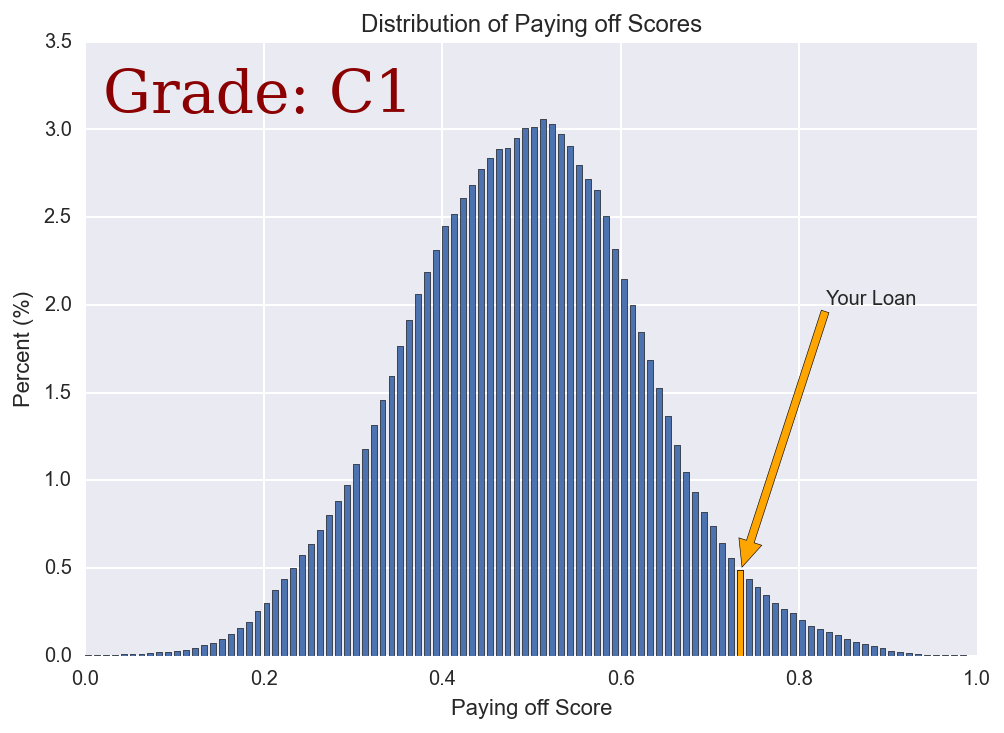

In [464]:
MODEL_ID = 7
Grade = 31
X_raw_proof = X_train
y_prob_proof = 1- np.array(y_cmb[MODEL_ID])

y_pred_proof = np.array(y_cmb_pred[MODEL_ID])
y_truth_proof = np.array(y_train)
N = 100
crit = np.linspace(0,1,N+1)
ratio = [] 
cnt = []
for i in crit:
    tmp = y_truth_proof[(y_prob_proof>=i) & (y_prob_proof<= (i+0.1)) & (X_raw_proof[:,15]==Grade)]
#     print i,len(tmp),len(tmp[tmp==1])
    cnt.append(len(tmp[tmp==1]))
    ratio.append(len(tmp[tmp==1])*1.0/(len(tmp)+0.0001))

ratio = np.array(ratio)
cnt = np.array(cnt)
plt.bar(crit,cnt/(sum(cnt)*0.01),width=0.99/(N*1.5))
plt.bar(crit[73],cnt[73]/(sum(cnt)*0.01),width=0.99/(N*1.5), color='orange')
plt.annotate('Your Loan', xy=(crit[73]+0.005, cnt[73]/(sum(cnt)*0.01)), xytext=(crit[73]+0.1, 2),
            arrowprops=dict(facecolor='orange', shrink=0.01)
            )

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 30,
        }
plt.text(crit[0]+0.02, 3.10, 'Grade: C1', fontdict=font)
plt.xlabel('Paying off Score')
plt.ylabel('Percent (%)')
plt.title('Distribution of Paying off Scores')

plt.xlim([0,1])
# plt.plot(1-crit,ratio)
plt.show()

In [ ]:
SubRecord = CleanUpRecord[CleanUpRecord.sub_grade=='C1']
SubRecord['Paid'] = SubRecord['stat']
SubRecord.Paid[SubRecord.Paid==-1] =0

In [309]:
StateData=SubRecord.groupby(['addr_state']).mean()
ZipData=SubRecord.groupby(['zip_code']).mean()

StateData.to_csv('StateData.csv', sep=',')
ZipData.to_csv('ZipData.csv', sep=',')

In [ ]:
# http://cdb.io/1R0a6u

In [285]:
from bokeh.plotting import figure, show, output_notebook

In [290]:
type(county_xs)

list

In [ ]:
colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]

In [283]:
sum(cnt)

61068

In [284]:
print 'Your loans beat %.2f' % (sum(cnt[0:73])*100.0/sum(cnt)), '% loans with the same grade'

Your loans beat 96.33 % loans with the same grade


In [242]:
MODEL_ID = 7
Grade = 23
X_raw_proof = X_train
y_prob_proof = np.array(y_cmb[MODEL_ID])

y_pred_proof = 1 - np.array(y_cmb_pred[MODEL_ID])
y_truth_proof = np.array(y_train)

Eg = []
for i in xrange(len(y_truth_proof)):
    if (X_raw_proof[i,15]==Grade) and y_prob_proof[i] > 0.73 and  y_prob_proof[i] < 0.74:
        Eg.append(i)
i = Eg[10]

print i,y_pred_proof[i],y_truth_proof[i],X_raw_proof[i],DictVectorT.feature_names_


91441 2.0 -1.0 [  6.24000000e+04   3.48100000e+01   7.00000000e+00   7.49000000e+02
   7.45000000e+02   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20000000e+04
   2.70000000e+01   1.00000000e+00   0.00000000e+00   2.30000000e+01
   3.60000000e+01   3.70000000e+01] ['annual_inc', 'dti', 'emp_length', 'fico_range_high', 'fico_range_low', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'loan_amnt', 'open_acc', 'policy_code', 'pub_rec', 'sub_grade', 'term', 'total_acc']


In [463]:
MODEL_ID = 7
Grade = 31
X_raw_proof = X_train
y_prob_proof = 1-np.array(y_cmb[MODEL_ID])

y_pred_proof = np.array(y_cmb_pred[MODEL_ID])
y_truth_proof = np.array(y_train)

Eg = []
for i in xrange(len(y_truth_proof)):
    if (X_raw_proof[i,15]==Grade) and y_prob_proof[i] > 0.73 and  y_prob_proof[i] < 0.74:
        Eg.append(i)
i = Eg[10]

print i,y_pred_proof[i],y_truth_proof[i],X_raw_proof[i],DictVectorT.feature_names_
print len(y_truth_proof[y_truth_proof[Eg]==1])*1.0/len(Eg)

35302 1.0 1.0 [  1.25000000e+05   2.32300000e+01   1.00000000e+01   7.24000000e+02
   7.20000000e+02   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20000000e+04
   1.60000000e+01   1.00000000e+00   0.00000000e+00   3.10000000e+01
   3.60000000e+01   4.20000000e+01] ['annual_inc', 'dti', 'emp_length', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'open_acc', 'policy_code', 'pub_rec', 'sub_grade', 'term', 'total_acc']
0.979591836735


In [23]:
# y_proba_rf= RFfit.predict_proba(X_test)
y_pred_rf = RFfit.predict(X_test)
y_pred_rf_train = RFfit.predict(Xy_train_bal[0][0])

In [451]:
i = 91441 
print i,y_pred_proof[i],y_truth_proof[i],X_raw_proof[i],DictVectorT.feature_names_


91441 -1.0 -1.0 [  6.24000000e+04   3.48100000e+01   7.00000000e+00   7.49000000e+02
   7.45000000e+02   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20000000e+04
   2.70000000e+01   1.00000000e+00   0.00000000e+00   2.30000000e+01
   3.60000000e+01   3.70000000e+01] ['annual_inc', 'dti', 'emp_length', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'open_acc', 'policy_code', 'pub_rec', 'sub_grade', 'term', 'total_acc']


In [26]:
def Compute_TPFN(y_pred,y_true):
    df = pd.DataFrame(columns=('y_pred','y_true','count'))
    df['y_pred'] = pd.Series(y_pred)
    df['y_true'] = pd.Series(np.array(y_true))
    df['count'] = 1
    return df.groupby(['y_pred','y_true']).count()

# print Compute_TPFN(y_pred_train,y_train)
print Compute_TPFN(y_pred_rf,y_test)
print Compute_TPFN(y_pred_rf_train,Xy_train_bal[0][1])



               count
y_pred y_true       
-1     -1       7162
        1      19425
 1     -1       3837
        1      31266
               count
y_pred y_true       
-1     -1      22392
 1      1      22392
22392 22392


GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=5, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [159]:
y_proba= clf.predict_proba(X_test)
# y_pred = clf.predict(X_test)
print Compute_TPFN(y_pred,y_test)

               count
y_pred y_true       
33391  33391   50350
       153546  10555
153546 33391     405
       153546    380


In [155]:
# RFfit =RandomForestClassifier(n_estimators=300)
# RFfit.fit(X_train,y_train,sample_weight=np.array(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [162]:
ytrain_proba_rf= RFfit.predict_proba(X_train)
ytrain_proba= clf.predict_proba(X_train)

In [51]:
y_proba= RFfit.predict_proba(X_vect)
# y_pred = RFfit.predict(X_vect)
# print Compute_TPFN(y_pred,y_test)

In [166]:
from sklearn.linear_model import LogisticRegression
cmb = np.array([y_proba_rf[:,0],y_proba[:,0]]).T
LRclf = LogisticRegression()
LRclf.fit(cmb,y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [167]:
y_pred_cmb = LRclf.predict(cmb)

In [170]:
print Compute_TPFN(y_pred_cmb,y_test)

               count
y_pred y_true       
33391  33391   50137
       153546  10377
153546 33391     618
       153546    558


In [61]:
for i in xrange(len(y_proba)):
    if y_proba[i,0]>0.7 and y_proba[i,0]<0.73:
        break
    

In [223]:
LoanGrade = 'C1'

PayOff_Prob = []
PayOff_True = []
for i in xrange(len(y_proba)):
    if X.sub_grade.iloc[i] == LoanGrade:
        PayOff_Prob.append(y_proba[i,0])
        PayOff_True.append(y_test.iloc[i]== 33391 )



In [224]:
P = np.linspace(0,1,10)
PayOff = pd.DataFrame()
PayOff_True = np.array(PayOff_True)
PayOff_Prob = np.array(PayOff_Prob)

C =[]
for p in P:
    C.append(sum(PayOff_True[(PayOff_Prob>=p) &(PayOff_Prob<=0.1+p)])*1.0
             /(len(PayOff_True[(PayOff_Prob>=p) &(PayOff_Prob<=0.1+p)])+1))

In [228]:
Baseline_P = sum(PayOff_True)*1.0/len(PayOff_True)
# Let us build a bench mark
Bench = 
for i in PayOff_Prob:
    

82.401412595644501

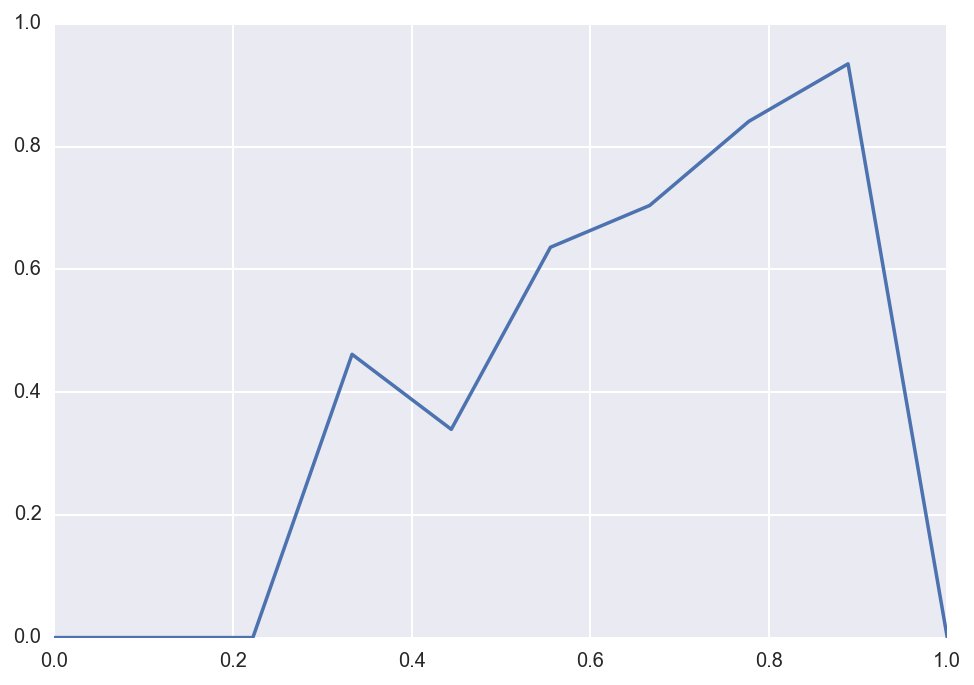

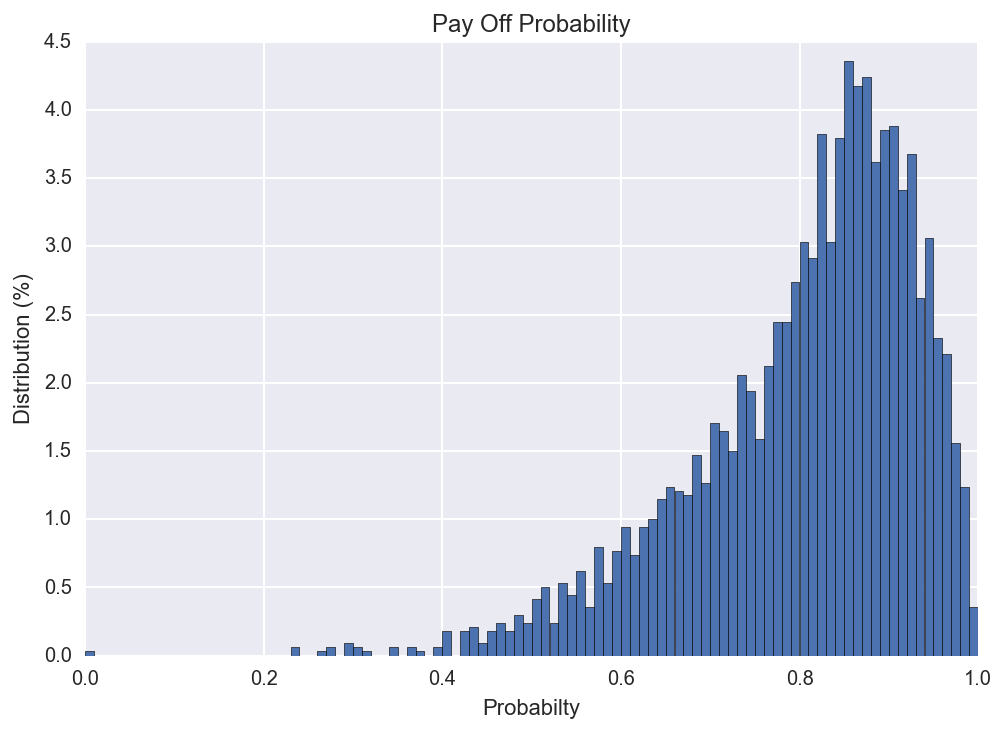

In [175]:
# # Generate a random sample.
n = 100
a,b=np.histogram(PayOff_Prob,bins = n)

plt.bar(np.arange(len(b)-1)*1.0/n, a*1.0/a.sum() * 100, width=0.99/n)
plt.xlim(0, 1)
plt.ylabel("Distribution (%)")
plt.xlabel("Probabilty")
plt.title('Pay Off Probability')

plt.show()

In [124]:
b

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
        0.99,  1.  ])

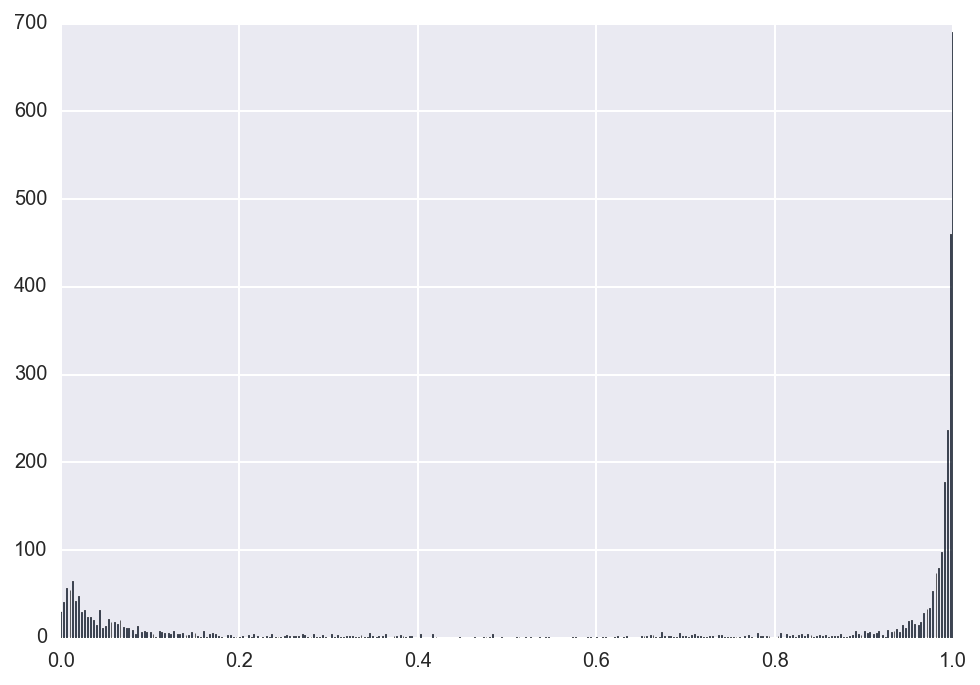

In [110]:
# np.unique(PayOff_Prob)
import matplotlib.pyplot as plt
# plt.plot((a*1.0/a.sum()))
plt.hist(PayOff_Prob,bins=1000)
plt.show()

In [70]:
print X.iloc[i]
print y.iloc[i]

annual_inc                   49200
dti                             20
emp_length               10+ years
home_ownership                RENT
loan_amnt                    10000
open_acc                        10
policy_code                      1
pub_rec                          0
sub_grade                       C1
term                     36 months
total_acc                       37
last_fico_range_high           579
last_fico_range_low            575
Name: 3, dtype: object
33391.0


In [44]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction import DictVectorizer

rfpipeline = Pipeline([('List2DictT',List2Dict_Transformer()), 
                       ('DictVectorT',DictVectorizer()),
                       ('RFfit',RandomForestClassifier())])
rfpipeline.set_params(List2DictT__str_keys=['home_ownership'],
                      DictVectorT__sparse=False,
                      RFfit__n_estimators=300,
                      RFfit__oob_score=True,
#                       RFfit__sample_weight=y_train,
                     )

# rfpipeline.fit(X_train,y_train)

Pipeline(steps=[('List2DictT', List2Dict_Transformer(str_keys=['home_ownership', 'sub_grade'])), ('DictVectorT', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('RFfit', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max...imators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))])

In [14]:
y_proba_test = rfpipeline.predict_proba(X_test)
y_proba_train = rfpipeline.predict_proba(X_train)

# y_pred_test = rfpipeline.predict(X_test)
# y_pred_train = rfpipeline.predict(X_train)

In [22]:
y_pred_test = rfpipeline.predict(X_test)
y_pred_train = rfpipeline.predict(X_train)

In [23]:
# Let us do a ROC:
def Proba2Pred(y_proba,cutoff=0.5):
    y_pred = np.ones(len(y_proba))
    y_pred[y_proba[:,0] > cutoff] = -1
    return y_pred

def Compute_TPFN(y_pred,y_true):
    df = pd.DataFrame(columns=('y_pred','y_true','count'))
    df['y_pred'] = pd.Series(y_pred)
    df['y_true'] = pd.Series(np.array(y_true))
    df['count'] = 1
    return df.groupby(['y_pred','y_true']).count()

print Compute_TPFN(y_pred_train,y_train)
print Compute_TPFN(y_pred_test,y_test)

                count
y_pred y_true        
-1     -1       22345
 1      1      102902
               count
y_pred y_true       
-1     -1        323
        1        331
 1     -1      10723
        1      50313


dict_values([DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False), List2Dict_Transformer(str_keys=['home_ownership', 'sub_grade'])])

In [ ]:
importance=[(tot_feat_vec.columns[i],clf2.feature_importances_[i]) for i in xrange(len(clf2.feature_importances_))]

importance = sorted(importance,key = lambda tup:tup[1],reverse=True)
print importance

In [158]:
# print y_pred_test[0],y_proba_test[0],len(y_pred_test)

1.0 [ 0.03  0.97] 61690


In [ ]:
# WHAT THE FUCK IS GOING ON. NO PREDICTIVE POWER NOW? MUST BE SOMETHING WRONG WITH THE PIPELINE
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction import DictVectorizer

# rfpipeline = Pipeline([('List2DictT',List2Dict_Transformer()), 
#                        ('DictVectorT',DictVectorizer()),
#                        ('RFfit',RandomForestClassifier())])
# rfpipeline.set_params(List2DictT__str_keys=['home_ownership','sub_grade'],
#                       DictVectorT__sparse=False,
#                       RFfit__n_estimators=1000,
#                       RFfit__oob_score=True)
# rfpipeline.fit(X_train,y_train)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [235]:
List2Dict_T =List2Dict_Transformer(str_keys=['home_ownership','sub_grade' ])
List2Dict_T.fit(df[relevant])    
X_dict= List2Dict_T.transform(df[relevant])

from sklearn.feature_extraction import DictVectorizer
DVect = DictVectorizer()
DVect.fit(X_dict)
X_vect = DVect.transform(X_dict)

In [212]:
DVect.feature_names_

['annual_inc',
 'dti',
 'emp_length',
 'fico_range_high',
 'fico_range_low',
 'home_ownership_ANY',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'loan_amnt',
 'open_acc',
 'policy_code',
 'pub_rec',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 'sub_grade_G2',
 'sub_grade_G3',
 'sub_grade_G4',
 'sub_grade_G5',
 'term',
 'total_acc']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X_vect.toarray(), y, test_size=0.33)


In [229]:
len(X)

186937

In [221]:
#%%
# Random forest regressor
clf2 = RandomForestClassifier(n_estimators=100,                     # number of trees in the forest
                        criterion='gini', max_depth=None, 
                        min_samples_split=2, min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0, max_features='auto',
                        max_leaf_nodes=None, bootstrap=True, oob_score=True, 
                        n_jobs=1, random_state=None, verbose=0, 
                        warm_start=False, class_weight=None)
# use the model to predict the k th data point
clf2.fit(X_train, y_train)


# clf2.fit(X_train, y_train)
# clf2.fit(X_train, y_train==1)
# import dill
# with open('./rf_lendingclub_p.pkl', 'wb') as out_strm:
#     dill.dump(clf2,out_strm)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [222]:
y_proba_test = clf2.predict_proba(X_test)
y_proba_train = clf2.predict_proba(X_train)

y_pred_test = clf2.predict(X_test)
y_pred_train = clf2.predict(X_train)

In [ ]:
y_pred_test= clf2.predict(X_test,y_test)

In [123]:
# y_prob=(rfpipeline.predict_proba(X_test))



# List2Dict_T =List2Dict_Transformer(str_keys=['home_ownership','sub_grade' ])

# List2Dict_T.fit(df[relevant])    
# X_dict= List2Dict_T.transform(df[relevant])

# from sklearn.feature_extraction import DictVectorizer
# DVect = DictVectorizer()
# DVect.fit(X_dict)
# X_vect = DVect.transform(X_dict)

In [148]:
# single recode example
# try whether pandas like dict or not
RequiredDict = {'sub_grade':'Grade assigned by Lending Club',
                'term':'Term',
                'fico_range_low': 'Fico Score (Low)',
                'fico_range_high':'Fico Score (High)',
                'loan_amnt':'Total Loan Amount',
                'annual_inc': 'Annual Income',
                'dti':'Debt to Income ratio',
                'emp_length':'Employment length',
                'open_acc':'Number of credit lines currently open',
                'total_acc':'Total credit lines',
                'pub_rec':'Public record',
                'policy_code':'Polic code',
                'home_ownership':'House Ownership'}
record = pd.DataFrame(RequiredDict,index=[0])


,annual_inc,dti,emp_length,fico_range_high,fico_range_low,home_ownership,loan_amnt,open_acc,policy_code,pub_rec,sub_grade,term,total_acc
0,Annual Income,Debt to Income ratio,Employment length,Fico Score (High),Fico Score (Low),House Ownership,Total Loan Amount,Number of credit lines currently open,Polic code,Public record,Grade assigned by Lending Club,Term,Total credit lines


In [13]:
pd.unique(tot_feat.emp_length)
tot_feat_vec = pd.get_dummies(tot_feat)
print tot_feat_vec.columns

Index([u'annual_inc', u'dti', u'emp_length', u'fico_range_high',
       u'fico_range_low', u'loan_amnt', u'open_acc', u'policy_code',
       u'pub_rec', u'term', u'total_acc', u'home_ownership_ANY',
       u'home_ownership_MORTGAGE', u'home_ownership_NONE',
       u'home_ownership_OTHER', u'home_ownership_OWN', u'home_ownership_RENT',
       u'sub_grade_A1', u'sub_grade_A2', u'sub_grade_A3', u'sub_grade_A4',
       u'sub_grade_A5', u'sub_grade_B1', u'sub_grade_B2', u'sub_grade_B3',
       u'sub_grade_B4', u'sub_grade_B5', u'sub_grade_C1', u'sub_grade_C2',
       u'sub_grade_C3', u'sub_grade_C4', u'sub_grade_C5', u'sub_grade_D1',
       u'sub_grade_D2', u'sub_grade_D3', u'sub_grade_D4', u'sub_grade_D5',
       u'sub_grade_E1', u'sub_grade_E2', u'sub_grade_E3', u'sub_grade_E4',
       u'sub_grade_E5', u'sub_grade_F1', u'sub_grade_F2', u'sub_grade_F3',
       u'sub_grade_F4', u'sub_grade_F5', u'sub_grade_G1', u'sub_grade_G2',
       u'sub_grade_G3', u'sub_grade_G4', u'sub_grade_G5'],
    

In [14]:
# Expore what is missing. Most of them is emp_info, 
# which is likely corresponding to unemployment rate
# So let us supply it with -1.


#######################
# keys =df.columns
# miss = []
# for key in keys:
#     if 'n/a' in pd.unique(df[key]):
#         miss.append(key)
# print miss        
# # ['emp_title', 'emp_length', 'desc', 'title']
    

In [15]:
# tot_feat.emp_length[np.isnan(tot_feat.emp_length.astype('float'))] = (tot_feat.emp_length[~np.isnan(tot_feat.emp_length.astype('float'))]).median()

# tot_feat.emp_length = pd.Series(tot_feat.emp_length.astype('int'))

In [16]:
# So far the filling nans is using global median, which is can be improved 
# use the relevant median instead. Removing the irrelavant information.
# To do so, let me explore what has nan. 
## Explore, which field has nan.
# keys =tot_feat.columns
# miss = []
# for key in keys:
#     print (pd.unique(tot_feat[key]))

# ONLY EMPLOYMENT AND DESC have NAN

In [17]:
tot_feat_vec.columns

Index([u'annual_inc', u'dti', u'emp_length', u'fico_range_high',
       u'fico_range_low', u'loan_amnt', u'open_acc', u'policy_code',
       u'pub_rec', u'term', u'total_acc', u'home_ownership_ANY',
       u'home_ownership_MORTGAGE', u'home_ownership_NONE',
       u'home_ownership_OTHER', u'home_ownership_OWN', u'home_ownership_RENT',
       u'sub_grade_A1', u'sub_grade_A2', u'sub_grade_A3', u'sub_grade_A4',
       u'sub_grade_A5', u'sub_grade_B1', u'sub_grade_B2', u'sub_grade_B3',
       u'sub_grade_B4', u'sub_grade_B5', u'sub_grade_C1', u'sub_grade_C2',
       u'sub_grade_C3', u'sub_grade_C4', u'sub_grade_C5', u'sub_grade_D1',
       u'sub_grade_D2', u'sub_grade_D3', u'sub_grade_D4', u'sub_grade_D5',
       u'sub_grade_E1', u'sub_grade_E2', u'sub_grade_E3', u'sub_grade_E4',
       u'sub_grade_E5', u'sub_grade_F1', u'sub_grade_F2', u'sub_grade_F3',
       u'sub_grade_F4', u'sub_grade_F5', u'sub_grade_G1', u'sub_grade_G2',
       u'sub_grade_G3', u'sub_grade_G4', u'sub_grade_G5'],
    

In [18]:
X = tot_feat_vec
y = tot_labl
y[y == -1] =0.0

In [19]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

 

In [21]:
importance=[(tot_feat_vec.columns[i],clf2.feature_importances_[i]) for i in xrange(len(clf2.feature_importances_))]

importance = sorted(importance,key = lambda tup:tup[1],reverse=True)
print importance

[('dti', 0.14921630604716682), ('annual_inc', 0.13258534033034525), ('loan_amnt', 0.12275184415376111), ('total_acc', 0.11382579484136307), ('open_acc', 0.096341302023195824), ('emp_length', 0.077147956277889146), ('fico_range_high', 0.054979184170717704), ('fico_range_low', 0.054523177401007601), ('term', 0.018518013685362329), ('pub_rec', 0.013381435856131692), ('home_ownership_RENT', 0.010406800454035321), ('home_ownership_MORTGAGE', 0.0099205152708521944), ('sub_grade_C4', 0.0073455739945508317), ('sub_grade_C3', 0.0073357408640482499), ('home_ownership_OWN', 0.0073034609276571173), ('sub_grade_C5', 0.0072360374067525646), ('sub_grade_C2', 0.0070448024670123456), ('sub_grade_C1', 0.006927868671440093), ('sub_grade_D1', 0.0065411206857874261), ('sub_grade_D2', 0.0063408303368668517), ('sub_grade_B4', 0.006208506207513299), ('sub_grade_D3', 0.0060826141391949994), ('sub_grade_B5', 0.005979251384428493), ('sub_grade_D4', 0.0059135084532431484), ('sub_grade_D5', 0.0056830201211188758),

In [35]:
tot_feat_vec.shape

(186937, 27)

In [158]:
y_pred = clf2.predict(tot_feat_vec)

In [165]:
tot_labl[tot_labl == -1] =0
Hits = sum(tot_labl[y_pred==1])
FalseAlarm = len(tot_labl[y_pred==1]) - Hits
Miss = sum(tot_labl[y_pred == 0])
CorrectRejection = len(tot_labl[y_pred == 0]) - Miss


In [13]:
# get the probability from the random forest
import dill
with open('./rf_lendingclub_p.pkl', 'rb') as in_strm:
    clf2 = dill.load(in_strm)


In [42]:
ap=clf2.predict_proba(tot_feat_vec)

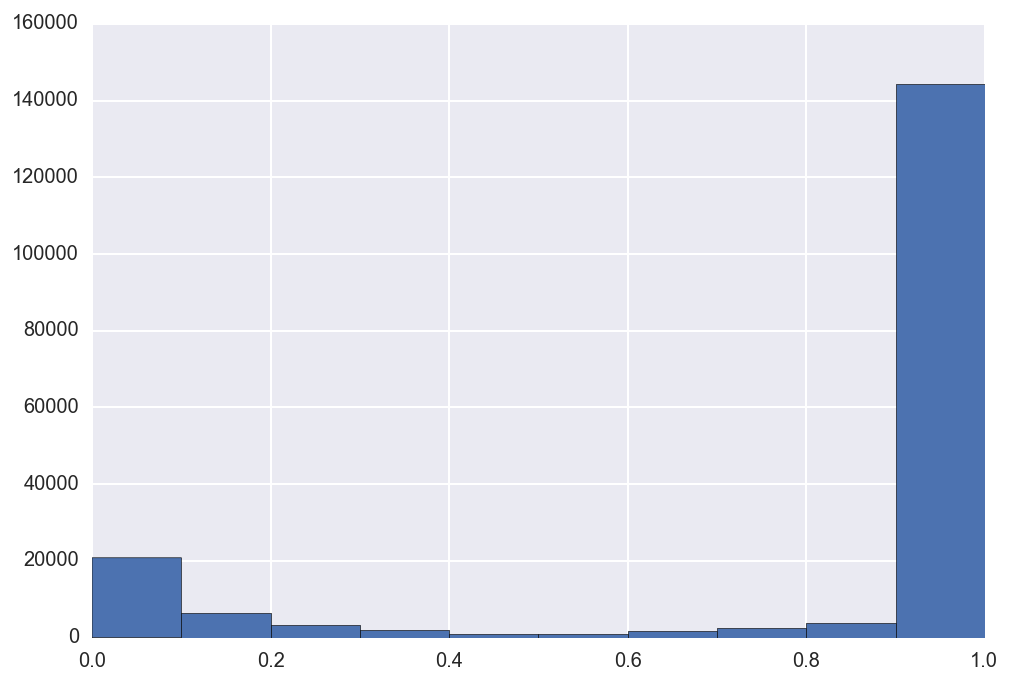

In [44]:
import matplotlib.pyplot as plt
plt.hist(ap[:,1])
plt.show()

In [205]:
LabelB = full.stat[full.grade=='B']
y_pred = np.array(y_pred)

len(y_predB),len(y_pred)

(56943, 186937)

In [239]:
# tot_labl[tot_labl == -1] =0
Grader = 'A'
LabelB = full.stat[full['grade']==Grader]
y_predB = y_pred[np.array(full.grade==Grader)]

money = full.loan_amnt[full.grade==Grader]

#
LabelB[LabelB==-1] = 0


Hits = sum(LabelB[y_predB==1])
FalseAlarm = len(LabelB[y_predB==1]) - Hits
Miss = sum(LabelB[y_predB == 0])
CorrectRejection = len(LabelB[y_predB == 0]) - Miss

print 'False alarm, should NOT have FUNDED -------',FalseAlarm*100.0/(Hits + FalseAlarm)
print 'Missing, should have FUNDED ---------------',Miss*100.0/(CorrectRejection + Miss)
print 'Default rate ------------------------------',(FalseAlarm + CorrectRejection)*100 / len(LabelB)

HitsMoney = sum(LabelB[y_predB==1]*money[y_predB==1])
FalseAlarmMoney = sum(money[y_predB==1]) - HitsMoney
MissMoney = sum(LabelB[y_predB == 0]*money[y_predB==0])
CorrectRejectionMoney = sum(money[y_predB == 0]) - MissMoney

print 'False alarm, should NOT have FUNDED -------',FalseAlarmMoney*100.0/(HitsMoney + FalseAlarmMoney)
print 'Missing, should have FUNDED ---------------',MissMoney*100.0/(CorrectRejectionMoney + MissMoney)
print 'Default rate ------------------------------',(FalseAlarmMoney + CorrectRejectionMoney)*100 / sum(money)

False alarm, should NOT have FUNDED ------- 0.529396290938
Missing, should have FUNDED --------------- 6.7081935793
Default rate ------------------------------ 6.48635342626
False alarm, should NOT have FUNDED ------- 0.454064324506
Missing, should have FUNDED --------------- 5.39836689138
Default rate ------------------------------ 6.24525867511


In [229]:
HitsMoney = sum(LabelB[y_predB==1]*money[y_predB==1])
FalseAlarmMoney = sum(money[y_predB==1]) - HitsMoney
MissMoney = sum(LabelB[y_predB == 0]*money[y_predB==0])
CorrectRejectionMoney = sum(money[y_predB == 0]) - MissMoney
print 'False alarm, should NOT have FUNDED -------',FalseAlarmMoney*100.0/(HitsMoney + FalseAlarmMoney)
print 'Missing, should have FUNDED ---------------',MissMoney*100.0/(CorrectRejectionMoney + MissMoney)
print 'Default rate ------------------------------',(FalseAlarmMoney + CorrectRejectionMoney)*100 / len(LabelBMoney)

 False alarm, should NOT have FUNDED ------- 0.788355076854
Missing, should have FUNDED --------------- 5.02276875905
Default rate ------------------------------

NameError: name 'LabelBMoney' is not defined

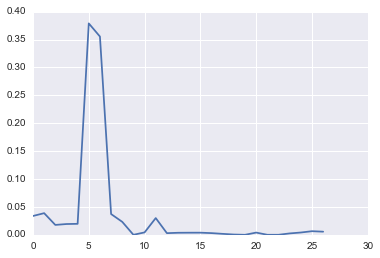

In [252]:
import matplotlib.pyplot as plt 
plt.figure
# plt.subplot(221)
plt.plot(clf2.feature_importances_)
# # plt.show()
# plt.subplot(222)
# plt.plot(clf2.feature_importances_)
plt.show()

In [131]:
y_pred=clf2.predict(X_test)


In [89]:
cnt = 0
baseline = 0
for i in xrange(len(y_test)):
    if y_test.iloc[i] == 1:
        baseline += 1
        if y_pred[i]:
            cnt += 1
    elif y_test.iloc[i] == -1 and not y_pred[i]:
        cnt += 1
        
# test_pred_err = clf2.oob_decision_function_
# test_pred = np.floor(test_pred_err[:,1] *2)
# test_pred[test_pred>=2] = 1
# print sum(abs(test_pred-train_labl))*100.0/len(train_labl)



0.27026752328324516

In [88]:
cnt*1.0 / len(y_test)*100

95.07051385962069

In [242]:
#%%
tot = train_feat
tot['pred'] = test_pred
tot['actu'] = labl

#%%
bin_edges[-1] += 1
rate = np.zeros(hist.shape)
payrate = np.zeros(hist.shape)
prate = np.zeros(hist.shape)
for i in range(len(bin_edges)-1):
    left_edge = bin_edges[i]
    right_edge = bin_edges[i+1]
    incid = df.stat[(df['loan_amnt'] >= left_edge) & (df['loan_amnt'] < right_edge)]
    amnt = df.loan_amnt[(df['loan_amnt'] >= left_edge) & (df['loan_amnt'] < right_edge)]
    rate[i] = len(incid[incid==1]) *1.0 / (len(incid[incid==1]) + len(incid[incid==-1]) )
    payrate[i] = (sum(amnt[incid==1]) + sum(amnt[incid==-1]) )




NameError: name 'test_pred' is not defined

In [241]:
#%%
for i in range(len(bin_edges)-1):
    left_edge = bin_edges[i]
    right_edge = bin_edges[i+1]
    incid = tot[(tot['loan_amnt'] >= left_edge) & (df['loan_amnt'] < right_edge)]
    rate[i] = len(incid[incid.actu == 1])*100.0/len(incid)
    prate[i] = len(incid[(incid.actu- incid.pred)==0])*100.0/len(incid)
    


NameError: name 'bin_edges' is not defined

In loans funded in Lending Club, about 15 percent of loans are a failure, and 85 % percent of the loans are successful. 
For loans of a large amount, the failure rate is particularly high. 

In [240]:
N = 10
menMeans   = rate
womenMeans = 100 - rate

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
# plt.subplot(211)
plt.figure()
p1 = plt.bar(ind, menMeans,   width, color='r',label='Success loans')
p2 = plt.bar(ind, womenMeans, width, color='y',label='Failure loans (charged off/Default)',
             bottom=menMeans)


plt.ylabel('Percentage')
# plt.title('successful loans versus failed loans')
plt.xticks(np.asarray([0,5,9])+width/2., ('5000','20000','35000') )
#plt.yticks(np.arange(0,81,10))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Loan Size ($)')
plt.show()

NameError: name 'rate' is not defined

The goal of my project is to predict whether a loan will be successful or not. 
To do that I downloaded data from lending club, selected several features to build a prediction model, including both numerical features, such as the annual income, the fico credit score, and also categorical features, such as the grade of the loan assigned by lending club. 

Using these features, I built a random forest model to predict whether the loan will be successful. 
The idea is to build a large number of decision trees, each is used to generate a prediction, and the final prediction is the average of these predictions from each tree. 
The strategy by my random forest model significantly decreases the chance of funding a failure loan, compared to the strategy by lending club, with a improvement of 40 %. 

In [221]:
# for i in range(len(bin_edges)-1):
#     left_edge = bin_edges[i]
#     right_edge = bin_edges[i+1]
#     incid = tot[(tot['loan_amnt'] >= left_edge) & (df['loan_amnt'] < right_edge)]
#     rate[i] = len(incid[incid.actu == 1])*100.0/len(incid)
#     prate[i] = len(incid[(incid.actu- incid.pred)==0])*100.0/len(incid)

# pold = 100-len(tot[tot.actu==1])*100.0/len(tot)
# pnew = 100-len(tot[(tot.actu-tot.pred)==0])*100.0/len(tot)
# print pold,pnew
# plt.figure()
# #plt.subplot(211)
# p1=plt.plot(bin_edges[:-1],100-rate,'b')
# p2=plt.plot(bin_edges[:-1],100-prate,'r')
# plt.xlabel('Loan Size ($)')
# plt.ylabel('Percent of failured loans')  
# plt.legend((p1[0],p2[0]),('Strategy by LendingClub', 'Strategy by my random forest model'))

# plt.title('Improved by %.2f %%' % ((pold-pnew)*100.0/pold))
# plt.show()

Moving forward, I would like to incorporate more features to further improve the model. One feature I am particular interested in the description of the loan provided by the borrower. It contains lots of details about the borrowers. I would also like to build a user interface to provide recommendation about whether or not one should fund a particular loan. 

In [3]:
x = ['a','b','c']
','.join(x)

'a,b,c'